In [1]:
%config Completer.use_jedi = False

In [11]:
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import os
import random
import unicodedata
from collections import Counter

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import  EarlyStopping

In [4]:
from nltk.tokenize import SyllableTokenizer
from nltk import word_tokenize
from nltk.util import ngrams

In [5]:
df_us = pd.read_csv('./data/us_gender.csv')

In [6]:
df_male = df_us[ df_us.gender == 'M' ].copy()
df_female = df_us[ df_us.gender == 'F' ].copy()

In [7]:
ls_male = list( df_male.name.unique())
ls_female = list( df_female.name.unique())

In [8]:
print('Ratio male-female ', len(ls_male)/len(ls_female))

Ratio male-female  0.662322838390564


In [9]:
ls_gender = [0]*len(ls_male) + [1]*len(ls_female)
ls_name   = ls_male + ls_female
df = pd.DataFrame( {'gender':ls_gender, 'name':ls_name})
df = df.sample(frac=1).reset_index(drop=True)
df.name =  df.name.map( lambda x: x.lower())

In [10]:
SSP = SyllableTokenizer()  
df['syllable'] = df.name.map( lambda x: SSP.tokenize( x) )

In [13]:
syllable = []
for x in df.syllable:
    syllable.extend(x)

In [18]:
s_list = Counter(syllable)

In [ ]:
syllable_list.keys()
syllable_list.values() 

In [19]:
s_dict = dict( (c, c) for c in set(syllable) )

for key, value in s_dict.items():
    if s_list[ key ] <= 2:
        s_dict[ key ] = '*'   

In [17]:
len(set(syllable_cpy))

2176

In [24]:
syllabe_to_int = dict((c, i) for i, c in enumerate(syllable))
int_to_syllabe = dict((i, c) for i, c in enumerate(syllable))

In [25]:
word_vec_length = df.name.apply(len).max()
char_vec_length = len(syllable)
output_labels   = 2

print(f"The input vector will have the shape {word_vec_length}x{char_vec_length}.")

The input vector will have the shape 15x5475.


In [28]:
def name_encoding(name_syllable):

    integer_encoded = [ syllabe_to_int[ s ] for s in name_syllable ]
    
    # Start one-hot-encoding
    onehot_encoded = list()
    
    for value in integer_encoded:
        # create a list of n zeros, where n is equal to the number of accepted characters
        letter = [0 for _ in range(char_vec_length)]
        letter[value] = 1
        onehot_encoded.append(letter)
        
    # Fill up list to the max length. Lists need do have equal length to be able to convert it into an array
    for _ in range(word_vec_length - len(name_syllable)):
        onehot_encoded.append([0 for _ in range(char_vec_length)])
        
    return onehot_encoded

# Encode the output labels
def label_binary_encoding(gender_series):
    labels = np.empty((0, 2))
    for n in gender_series:
        x = [1,0] if n == 0 else [0,1]
        labels = np.append(labels, [x], axis=0)
    return labels

# Encode the output labels
def label_encoding(gender_series):
    labels = np.empty((0, 3))
    for n in gender_series:
        x = [0,0,0]
        x[n] = 1        
        labels = np.append(labels, [x], axis=0)
    return labels

In [29]:
train, test = np.split(df.sample(frac=1), [int(.8*len(df))])

# Convert both the input names as well as the output lables into the discussed machine readable vector format
train_x =  np.asarray([np.asarray(name_encoding(name_syllable)) for name_syllable in train.syllable])
train_y = label_binary_encoding(train.gender)

test_x = np.asarray([name_encoding(name_syllable) for name_syllable in test.syllable])
test_y = label_binary_encoding(test.gender)

In [30]:
hidden_nodes = 1024   # int(2/3 * (word_vec_length * char_vec_length))
#print(f"The number of hidden nodes is {hidden_nodes}.")

In [31]:
model = Sequential()
model.add(LSTM( hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
model.add(Dropout(0.2))

model.add(Dense( units= hidden_nodes//2 ))
model.add(Dropout(0.2))

model.add(Dense(units=output_labels))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1024)              26624000  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 27,149,826
Trainable params: 27,149,826
Non-trainable params: 0
____________________________________________

In [212]:
callbacks = [ EarlyStopping(  monitor='val_loss', mode='min'  ) ]

In [ ]:
history = model.fit(train_x, train_y, batch_size=256, epochs=10, validation_data=(test_x, test_y)) #callbacks=callbacks

Epoch 1/10
  8/110 [=>............................] - ETA: 6:30 - loss: 0.6829 - acc: 0.5689

<AxesSubplot:>

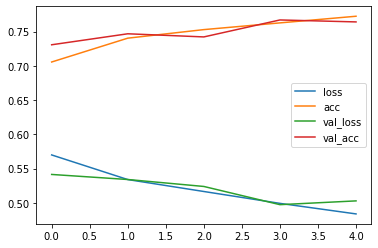

In [210]:
sdf = pd.DataFrame(history.history)
sdf.plot()

In [146]:
from sklearn.metrics import confusion_matrix

In [149]:
y_pred =  [0 if p[0] > p[1] else 1 for p in model.predict(test_x)]

In [150]:
confusion_matrix( test.gender.values, y_pred)

array([[3490, 2238],
       [1124, 4363]])